<a href="https://colab.research.google.com/github/Rahul-dsml/Myprojects/blob/main/skin_cancer_using_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


Importing relevant libraries

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import seaborn as sns

import PIL

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Reading and understanding the data

In [ ]:
!unzip /content/drive/MyDrive/UpGrad/Deep_Learning/CNN_assignment.zip

Creating path position for train and test data

In [4]:
data_dir_train= pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test= pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
#Counting images for train and test dataset
train_images= len(list(data_dir_train.glob('*/*.jpg')))
test_images= len(list(data_dir_test.glob('*/*.jpg')))
print("Total images in train folder are: ", train_images)
print("Total images in test folder are: ", test_images)

Total images in train folder are:  2239
Total images in test folder are:  118


In [6]:
#Setting the parameters
Batch_size= 64
img_height= 180
img_width= 180

In [7]:
#Creating tf datasets
train_ds= tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                              seed= 123, 
                                                              validation_split=0.2, 
                                                              subset= 'training',
                                                              image_size= (img_height, img_width),
                                                              batch_size= Batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
validation_ds= tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                              seed= 123, 
                                                              validation_split=0.2, 
                                                              subset= 'validation',
                                                              image_size= (img_height, img_width),
                                                              batch_size= Batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
class_names= train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Data Visualization

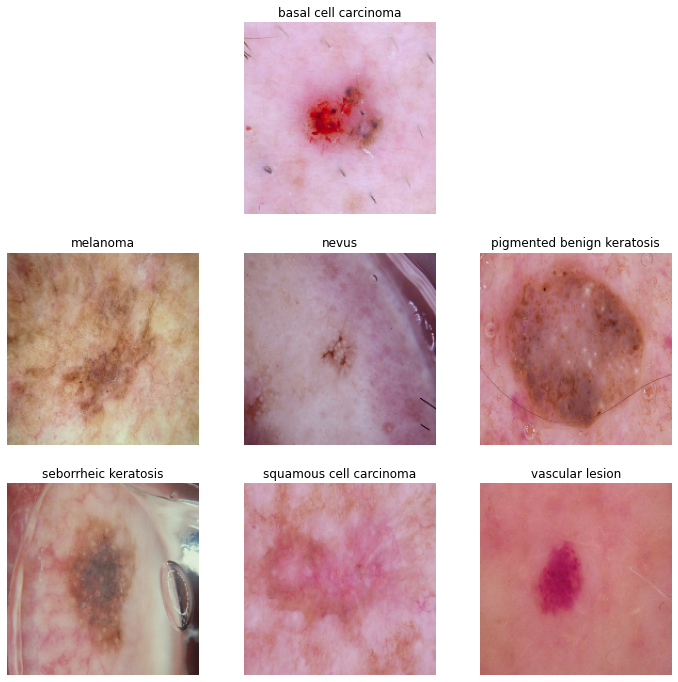

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

In [19]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
AUTOTUNE= tf.data.experimental.AUTOTUNE
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size= AUTOTUNE)
validation_ds= validation_ds.cache().prefetch(buffer_size= AUTOTUNE)

Creating the model using Transfer Learning

In [21]:
from keras.applications.vgg16 import VGG16, preprocess_input
img_shape= [180,180]

vgg= VGG16(input_shape= img_shape + [3], weights= 'imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable=False


58900480/58889256 [==============================] - 0s 0us/step


In [22]:
from keras.layers import Flatten, Dense, Lambda
from keras.models import Model
x= Flatten()(vgg.output)
x1= Dense(64, activation='relu')(x)
x2= Dense(128, activation='relu')(x1)

In [24]:
from keras.engine.training import Model
prediction= Dense(len(class_names))(x2)
model= Model(inputs= vgg.input, outputs = prediction)

In [25]:
model.compile(optimizer= 'adam',
                  loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [27]:
epochs=15
history= model.fit(train_ds,
              validation_data= validation_ds,
              epochs=epochs)

Epoch 1/15
28/28 [==============================] - 34s 467ms/step - loss: 2.5102 - accuracy: 0.2662 - val_loss: 1.9845 - val_accuracy: 0.3311
Epoch 2/15
28/28 [==============================] - 7s 249ms/step - loss: 1.4171 - accuracy: 0.5061 - val_loss: 1.7741 - val_accuracy: 0.4094
Epoch 3/15
28/28 [==============================] - 7s 250ms/step - loss: 1.0258 - accuracy: 0.6328 - val_loss: 1.7626 - val_accuracy: 0.4474
Epoch 4/15
28/28 [==============================] - 7s 251ms/step - loss: 0.6997 - accuracy: 0.7511 - val_loss: 1.8253 - val_accuracy: 0.4899
Epoch 5/15
28/28 [==============================] - 7s 253ms/step - loss: 0.4931 - accuracy: 0.8298 - val_loss: 1.8947 - val_accuracy: 0.4586
Epoch 6/15
28/28 [==============================] - 7s 254ms/step - loss: 0.3585 - accuracy: 0.8700 - val_loss: 1.9349 - val_accuracy: 0.4989
Epoch 7/15
28/28 [==============================] - 7s 256ms/step - loss: 0.2730 - accuracy: 0.8945 - val_loss: 2.1056 - val_accuracy: 0.4855
Epoch

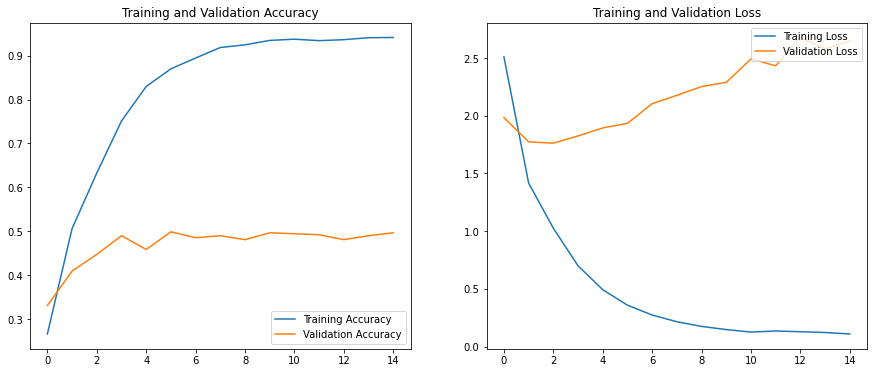

In [30]:
epochs=15
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model is highly OVERFITTING!!

Visualizing the label distribution

In [31]:
from glob import glob
lesion_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, "*", "*.jpg")) ]
len(lesion_list)

2239

In [32]:
len(set(lesion_list))

9

In [33]:
label_dict={}
for i in class_names:
  label_dict[i]= lesion_list.count(i)

print(label_dict)

{'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


In [34]:
label_df= pd.DataFrame(label_dict.items(), columns= ['class_name', 'count'])
label_df

,class_name,count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


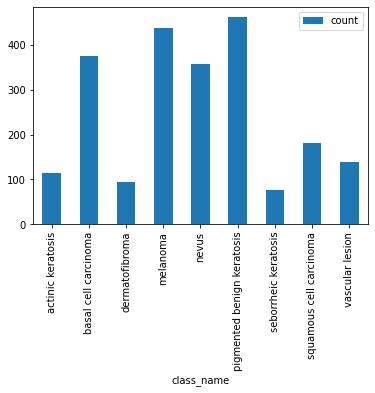

In [35]:
label_df.plot.bar(x= 'class_name', y='count')

In [36]:
label_df['%age']= round((label_df['count']/2239)*100, 2)
label_df.sort_values(by= '%age', ascending=False)

,class_name,count,%age
5,pigmented benign keratosis,462,20.63
3,melanoma,438,19.56
1,basal cell carcinoma,376,16.79
4,nevus,357,15.94
7,squamous cell carcinoma,181,8.08
8,vascular lesion,139,6.21
0,actinic keratosis,114,5.09
2,dermatofibroma,95,4.24
6,seborrheic keratosis,77,3.44


Highly imbalance data, also images for some categories are too less for training

In [37]:
!pip install Augmentor

In [38]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(600) ## We are adding 600 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F147818ABD0>: 100%|██████████| 600/600 [00:23<00:00, 25.91 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F147818A0D0>: 100%|██████████| 600/600 [00:22<00:00, 26.29 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1478113890>: 100%|██████████| 600/600 [00:22<00:00, 26.25 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F14785C7ED0>: 100%|██████████| 600/600 [01:47<00:00,  5.56 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F147B9BBF10>: 100%|██████████| 600/600 [01:53<00:00,  5.29 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F147865E050>: 100%|██████████| 600/600 [00:19<00:00, 30.81 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F150054EBD0>: 100%|██████████| 600/600 [00:48<00:00, 12.33 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F15295A9810>: 100%|██████████| 600/600 [00:19<00:00, 30.20 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F147BB595D0>: 100%|██████████| 600/600 [00:20<00:00, 29.56 Samples/s]


In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

5400


### Training the model after Augmentor

In [44]:
train_ds_new= tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                                  seed=123,
                                                                  subset='training',
                                                                  batch_size= Batch_size,
                                                                  image_size= (img_height, img_width),
                                                                  validation_split=0.2,
                                                                  )

Found 7639 files belonging to 9 classes.
Using 6112 files for training.


In [45]:
validation_ds_new= tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                                       seed=123,
                                                                       subset='validation',
                                                                       batch_size= Batch_size,
                                                                       image_size= (img_height, img_width),
                                                                       validation_split=0.2)

Found 7639 files belonging to 9 classes.
Using 1527 files for validation.


In [46]:
x= Flatten()(vgg.output)
x1= Dense(64, activation='relu')(x)
x2= Dense(128, activation='relu')(x1)

In [47]:
prediction= Dense(len(class_names))(x2)
model= Model(inputs= vgg.input, outputs = prediction)

In [48]:
model.compile(optimizer= 'adam',
                  loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [49]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0   

In [50]:
epochs=15
history= model.fit(train_ds_new,
              validation_data= validation_ds_new,
              epochs=epochs)

Epoch 1/15
96/96 [==============================] - 37s 367ms/step - loss: 1.6577 - accuracy: 0.4548 - val_loss: 1.0723 - val_accuracy: 0.6090
Epoch 2/15
96/96 [==============================] - 31s 310ms/step - loss: 0.7188 - accuracy: 0.7479 - val_loss: 0.8395 - val_accuracy: 0.7302
Epoch 3/15
96/96 [==============================] - 32s 320ms/step - loss: 0.4148 - accuracy: 0.8567 - val_loss: 0.6312 - val_accuracy: 0.7872
Epoch 4/15
96/96 [==============================] - 32s 313ms/step - loss: 0.2710 - accuracy: 0.9046 - val_loss: 0.5538 - val_accuracy: 0.8330
Epoch 5/15
96/96 [==============================] - 31s 313ms/step - loss: 0.1925 - accuracy: 0.9300 - val_loss: 0.5710 - val_accuracy: 0.8245
Epoch 6/15
96/96 [==============================] - 32s 313ms/step - loss: 0.1670 - accuracy: 0.9396 - val_loss: 0.5652 - val_accuracy: 0.8441
Epoch 7/15
96/96 [==============================] - 32s 313ms/step - loss: 0.1919 - accuracy: 0.9328 - val_loss: 0.7678 - val_accuracy: 0.7937

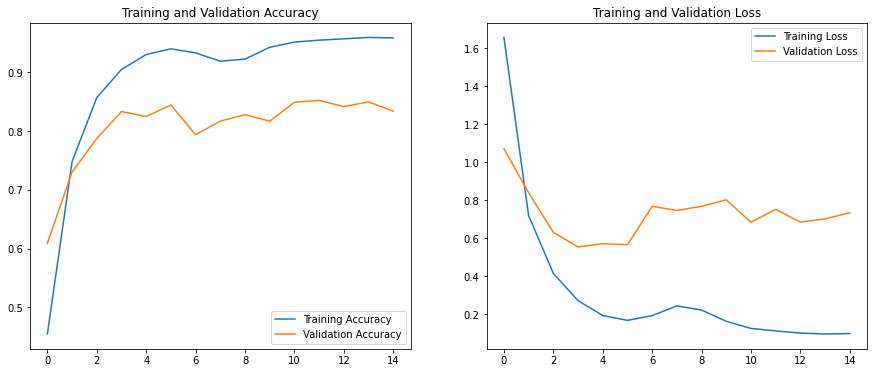

In [51]:
epochs=15
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model is a good model with training accuracy of 95.8 % and validation accuracy of 83.3%.
